# Build nearest neighbor graph of spikes using spikeinterface spikesorting modules
- this notebooks 
    1. grabs all spikes in a recording (found with detect peaks) 
    2. computes sparse euclidean nearest neighbors over chunks of the recording
    3. merges that graph into a single nearest neighbors graph

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import spikeinterface.full as si
import probeinterface
from probeinterface.plotting import plot_probe
import matplotlib.pyplot as plt
import numpy as np

In [3]:
base_folder = Path('/n/groups/datta/tim_sainburg/datasets/guitchounts_2_22/')
dataset_folder = base_folder/'Record Node 106'
probe_file = base_folder / 'A4x16-Poly3-5mm-20-200-160-H64LP.prb'

### Load dataset

In [4]:
rec = si.read_openephys(dataset_folder)
probe = probeinterface.io.read_prb(probe_file)
rec = rec.set_probe(probe.probes[0])

/n/groups/datta/tim_sainburg/datasets/guitchounts_2_22/Record Node 106/experiment1/recording1/continuous/Rhythm_FPGA-103.0/continuous.dat
/n/groups/datta/tim_sainburg/datasets/guitchounts_2_22/Record Node 106/experiment1/recording1/continuous/Rhythm_FPGA-103.0/continuous.dat


In [186]:
rec.get_num_channels()

64

In [5]:
probe.probes[0]._contact_positions[:,0]

array([  0. ,   0. ,   0. ,   0. ,   0. ,  17.3,  17.3,  17.3,  17.3,
        17.3,  17.3,  34.6,  34.6,  34.6,  34.6,  34.6, 200. , 200. ,
       200. , 200. , 200. , 217.3, 217.3, 217.3, 217.3, 217.3, 217.3,
       234.6, 234.6, 234.6, 234.6, 234.6, 400. , 400. , 400. , 400. ,
       400. , 417.3, 417.3, 417.3, 417.3, 417.3, 417.3, 434.6, 434.6,
       434.6, 434.6, 434.6, 600. , 600. , 600. , 600. , 600. , 617.3,
       617.3, 617.3, 617.3, 617.3, 617.3, 634.6, 634.6, 634.6, 634.6,
       634.6])

In [6]:
probe_positions = probe.probes[0]._contact_positions
margin = 100
probe_bounds_x = [
    np.min(probe_positions[:, 0]) - margin,
    np.max(probe_positions[:, 0]) + margin,
]
probe_bounds_y = [
    np.min(probe_positions[:, 1]) - margin,
    np.max(probe_positions[:, 1] + margin),
]

In [7]:
job_kwargs = dict(
    n_jobs=-1,
    chunk_memory='10M',
    progress_bar=True,
)

In [8]:
preprocess_folder = base_folder / 'spikeinterface-preprocess'

In [9]:
# load back
rec_preprocessed = si.load_extractor(preprocess_folder)
rec_preprocessed

BinaryRecordingExtractor: 64 channels - 1 segments - 30.0kHz - 4341.330s
  file_paths: ['/n/groups/datta/tim_sainburg/datasets/guitchounts_2_22/spikeinterface-preprocess/traces_cached_seg0.raw']

In [10]:
peak_folder = base_folder / 'spikeinterface_peaks'
peaks_file = peak_folder / 'peaks.npy'
peaks = np.load(peaks_file)

In [11]:
peaks[:2]

array([( 936, 3, -1304., 0), (2037, 3, -1352., 0)],
      dtype=[('sample_ind', '<i8'), ('channel_ind', '<i8'), ('amplitude', '<f8'), ('segment_ind', '<i8')])

In [12]:
peak_location_file = peak_folder / 'peak_locations_monopolar_triangulation.npy'
peak_locations = np.load(peak_location_file)

(-65.0, 235.0)

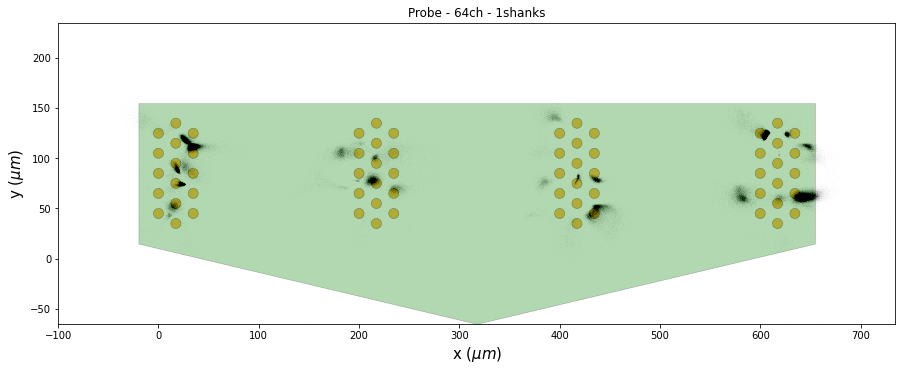

In [13]:
probe = rec_preprocessed.get_probe()
fig, ax = plt.subplots(figsize=(15, 10))
plot_probe(probe, ax=ax)
ax.scatter(peak_locations['x'], peak_locations['y'], color='k', s=1, alpha=0.002)
ax.set_xlim(probe_bounds_x)
ax.set_ylim(probe_bounds_y)

In [147]:
### Parameters
refractory_period_ms = 1.0 # number of milliseconds surrounding spike to not allow neighborhood
time_window_s = 60*5 # window for sampling nearest neighbors
margin_ms = 100 # margin for chunking
spike_pre_ms = 1 # time prior to peak
spike_post_ms = 1 # time after peak
n_channel_neighbors = 8 # number of neighbors per channel 
n_neighbors = 5 # number of neighbors for graph construction
knn_verbose = True # whether to make knn computation verbose
low_memory = False # memory usage
n_jobs = -1 # number of jobs to perform computations over

In [148]:
nn_idx = np.load(peak_folder / 'nearest_neighbor_index.npy')
nn_dist = np.load(peak_folder / 'nearest_neighbor_distances.npy')

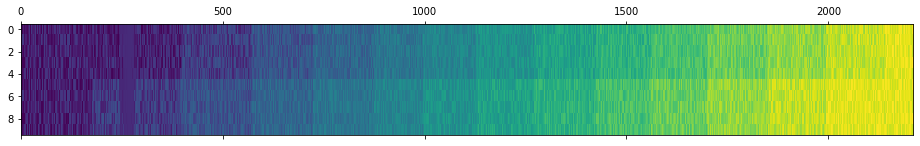

In [149]:
plt.matshow(nn_idx[::100].T, aspect='auto');

#### project and cluster

In [150]:
recording = rec_preprocessed

In [151]:
nn_index_array = nn_idx
nn_dist_array = nn_dist
embedding_dim = 2

In [152]:
n_frames = recording.get_num_frames()
fs = recording.get_sampling_frequency()
n_frames = recording.get_num_frames()
time_window_frames = fs * time_window_s
n_chunks = int(np.ceil(n_frames / time_window_frames))
n_spikes = len(nn_index_array)
mde_device= 'cuda'
n_chunks

15

In [153]:
### get indices of chunks
chunk_idx = np.zeros(len(peaks))
for chunk in range(n_chunks - 1):
    # set the start and end frame to grab for this chunk
    start_frame = int(chunk * time_window_frames)
    end_frame = int((chunk + 2) * time_window_frames)
    if end_frame > n_frames:
        end_frame = n_frames
    
    chunk_idx[(
        (peaks['sample_ind'] >= start_frame) &
        (peaks['sample_ind'] < end_frame)
    )] = chunk

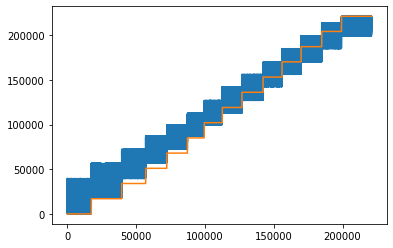

In [154]:
plt.plot(nn_idx[:,6])
plt.plot(chunk_idx * len(nn_idx)/np.max(chunk_idx))

In [155]:
from scipy.sparse import coo_matrix
import pymde

In [156]:
def grab_graph_chunk(chunk_idx, chunk, nn_index_array, nn_dist_array):
    chunk_start = np.where(chunk_idx==chunk)[0][0]
    
    # get the indices of the current 
    index_cur = chunk_idx == chunk
    index_next = chunk_idx == chunk+1
    
    # grab current chunk of the nn graph indices
    chunk_graph_cur = nn_index_array[index_cur, n_neighbors:]
    chunk_graph_next = nn_index_array[index_next, :n_neighbors]
    chunk_graph_idx = np.vstack([chunk_graph_cur, chunk_graph_next]) - chunk_start
    
    # grab the distances of the current chunk of the nn graph
    chunk_graph_cur = nn_dist_array[index_cur, n_neighbors:]
    chunk_graph_next = nn_dist_array[index_next, :n_neighbors]
    chunk_graph_vals = np.vstack([chunk_graph_cur, chunk_graph_next])
    
    return chunk_graph_idx, chunk_graph_vals, index_cur, index_next

In [157]:
def construct_symmetric_graph_from_idx_vals(graph_idx, graph_vals):
    rows = chunk_graph_idx.flatten()
    cols = np.repeat(np.arange(len(graph_idx)), graph_idx.shape[1])
    rows_ = np.concatenate([rows, cols])
    cols_ = np.concatenate([cols, rows])
    vals = graph_vals.flatten()
    
    # matrix
    # TODO: rather than weighting at 1, we can compute local distance
    #   using the UMAP algorithm: 
    #   https://github.com/lmcinnes/umap/blob/master/umap/umap_.py#L575
    chunk_csr = coo_matrix(
        (np.ones(len(rows_)), (rows_, cols_)),
        shape=(len(graph_idx), len(graph_idx)),
    ).tocsr()
    return chunk_csr

In [158]:
import torch

In [159]:
def embed_graph(chunk_csr, prev_embeddings=None, prev_idx=None, negative_to_positive_samples = 5):
    # graph size
    n_items = chunk_csr.shape[1]

    # grate graph as pymde graph
    knn_graph = pymde.Graph(chunk_csr)

    # constrain embeddings
    if prev_embeddings is not None:
        anchor_constraint = pymde.Anchored(
            anchors=torch.tensor(prev_idx, device=mde_device), values=torch.tensor(prev_embeddings, dtype=torch.float32, device=mde_device)
        )
    else:
        anchor_constraint = None
    
    # initialize with quadratic embedding
    quadratic_mde = pymde.MDE(
        n_items=n_items,
        embedding_dim=2,
        edges=knn_graph.edges,
        distortion_function=pymde.penalties.Quadratic(knn_graph.weights),
        constraint=anchor_constraint,
        device=mde_device
    )
    
    # embed quadratic initialization
    x =quadratic_mde.embed(verbose=True).cpu()
    
    # get all nearest neighbor edges
    similar_edges = knn_graph.edges

    # sample a set of dissimilar edges
    n_dis = int(len(similar_edges)*negative_to_positive_samples)
    dissimilar_edges = pymde.preprocess.dissimilar_edges(
        n_items=n_items, num_edges=n_dis, similar_edges=similar_edges
    )
    # created a list of weights for similar and dissimilar edges
    edges = torch.cat([similar_edges, dissimilar_edges])
    weights = torch.cat(
        [knn_graph.weights, -1.0 * torch.ones(dissimilar_edges.shape[0])]
    )

    # create a distortion penalty
    f = pymde.penalties.PushAndPull(
        weights=weights,
        attractive_penalty=pymde.penalties.Log1p,
        repulsive_penalty=pymde.penalties.Log,
    )
    
    # prepare MDE object
    std_mde = pymde.MDE(
        n_items=n_items,
        embedding_dim=embedding_dim,
        edges=edges,
        distortion_function=f,
        constraint=anchor_constraint,
        # constraint=pymde.Standardized(),
        device=mde_device,
    )

    # embed MDE
    x = std_mde.embed(quadratic_mde.X, max_iter=400, verbose=True)

    if mde_device == "cuda":
        x = np.array(x.cpu())

    return x

In [160]:
from tqdm.auto import tqdm

  0%|          | 0/14 [00:00<?, ?it/s]

chunk 0
Mar 13 03:29:40 PM: edges.device (cpu) does not match requested device (cuda); copying edges to requested device.
Mar 13 03:29:40 PM: distortion_function device (cpu) does not match requested device (cuda); making a copy of distortion_function
Mar 13 03:29:40 PM: Fitting a centered embedding into R^2, for a graph with 39576 items and 169385 edges.
Mar 13 03:29:40 PM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Mar 13 03:29:40 PM: iteration 000 | distortion 4.695739 | residual norm 0.0411725 | step length 382.174 | percent change 5.57315
Mar 13 03:29:40 PM: iteration 030 | distortion 0.000112 | residual norm 7.15863e-05 | step length 1 | percent change 4.26595
Mar 13 03:29:40 PM: iteration 060 | distortion 0.000011 | residual norm 1.70535e-05 | step length 1 | percent change 1.67055
Mar 13 03:29:40 PM: Converged in 079 iterations, with residual norm 9.46319e-06
Mar 13 03:29:40 PM: Finished fitting in 0.239 seconds and 79 iterations.
Mar 13 03:29:40 PM: a

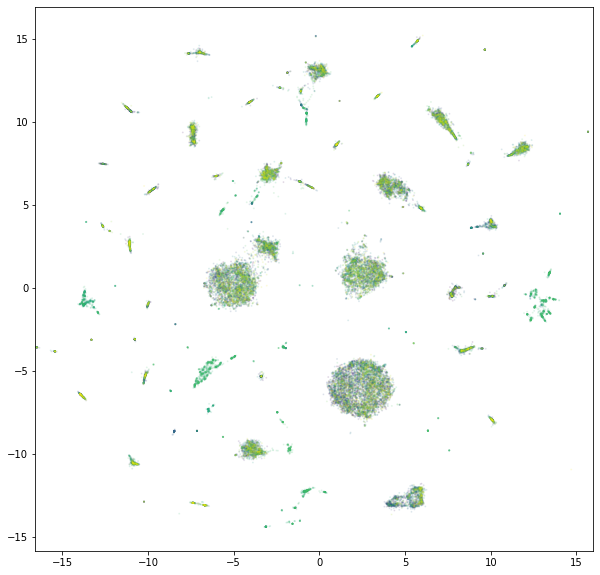

chunk 1
Mar 13 03:29:44 PM: edges.device (cpu) does not match requested device (cuda); copying edges to requested device.
Mar 13 03:29:44 PM: distortion_function device (cpu) does not match requested device (cuda); making a copy of distortion_function
Mar 13 03:29:44 PM: Fitting a anchored embedding into R^2, for a graph with 39494 items and 168750 edges.
Mar 13 03:29:44 PM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Mar 13 03:29:44 PM: iteration 000 | distortion 49.968876 | residual norm 0.0929311 | step length 2596.71 | percent change 16.5709
Mar 13 03:29:45 PM: iteration 030 | distortion 3.769793 | residual norm 0.000469925 | step length 1 | percent change 0.147807
Mar 13 03:29:45 PM: Converged in 054 iterations, with residual norm 8.32578e-06
Mar 13 03:29:45 PM: Finished fitting in 0.267 seconds and 54 iterations.
Mar 13 03:29:45 PM: average distortion 3.77 | residual norm 8.3e-06
Mar 13 03:29:46 PM: edges.device (cpu) does not match requested device (cuda

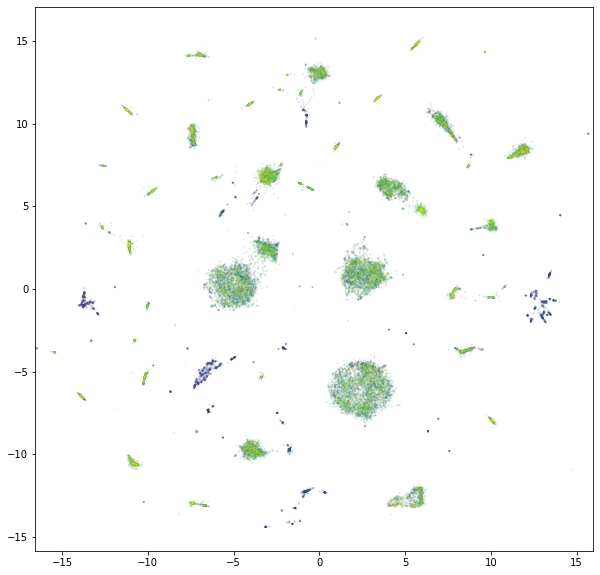

chunk 2
Mar 13 03:29:47 PM: edges.device (cpu) does not match requested device (cuda); copying edges to requested device.
Mar 13 03:29:47 PM: distortion_function device (cpu) does not match requested device (cuda); making a copy of distortion_function
Mar 13 03:29:47 PM: Fitting a anchored embedding into R^2, for a graph with 32756 items and 140523 edges.
Mar 13 03:29:47 PM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Mar 13 03:29:47 PM: iteration 000 | distortion 51.230602 | residual norm 0.106378 | step length 1344.33 | percent change 11.1218
Mar 13 03:29:47 PM: iteration 030 | distortion 1.241141 | residual norm 0.000119425 | step length 1 | percent change 0.00624065
Mar 13 03:29:47 PM: Converged in 041 iterations, with residual norm 4.32128e-06
Mar 13 03:29:47 PM: Finished fitting in 0.126 seconds and 41 iterations.
Mar 13 03:29:47 PM: average distortion 1.24 | residual norm 4.3e-06
Mar 13 03:29:48 PM: edges.device (cpu) does not match requested device (cud

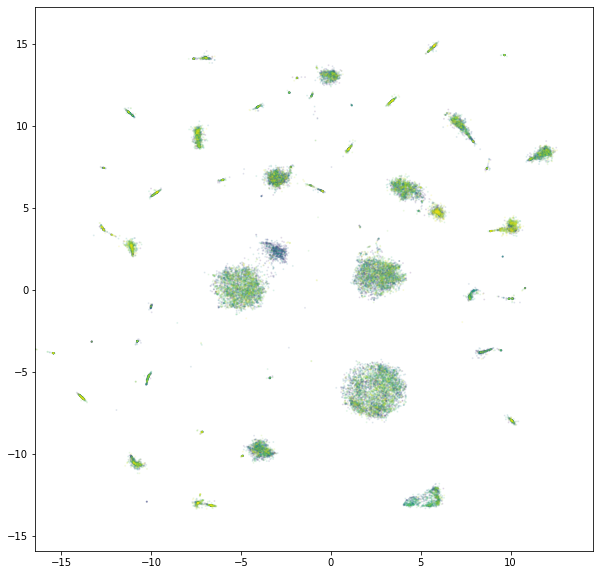

chunk 3
Mar 13 03:29:49 PM: edges.device (cpu) does not match requested device (cuda); copying edges to requested device.
Mar 13 03:29:49 PM: distortion_function device (cpu) does not match requested device (cuda); making a copy of distortion_function
Mar 13 03:29:49 PM: Fitting a anchored embedding into R^2, for a graph with 30297 items and 129870 edges.
Mar 13 03:29:49 PM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Mar 13 03:29:49 PM: iteration 000 | distortion 58.953434 | residual norm 0.117007 | step length 2173.47 | percent change 20.6987
Mar 13 03:29:49 PM: iteration 030 | distortion 0.972483 | residual norm 3.89081e-05 | step length 1 | percent change 0.0118135
Mar 13 03:29:49 PM: Converged in 048 iterations, with residual norm 8.83866e-06
Mar 13 03:29:49 PM: Finished fitting in 0.189 seconds and 48 iterations.
Mar 13 03:29:49 PM: average distortion 0.972 | residual norm 8.8e-06
Mar 13 03:29:50 PM: edges.device (cpu) does not match requested device (cud

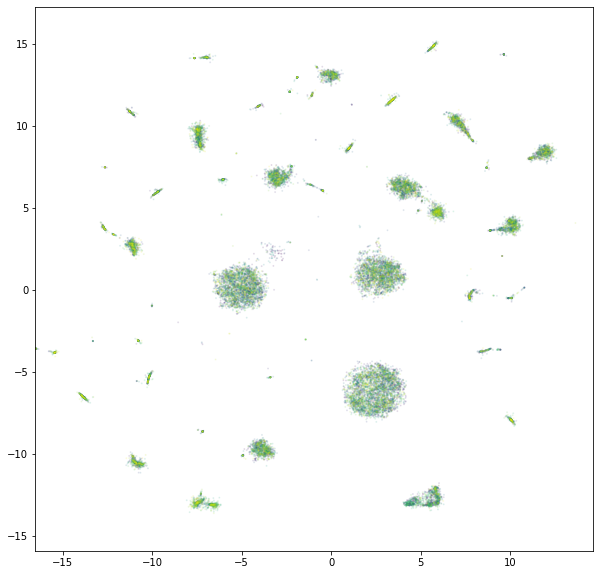

chunk 4
Mar 13 03:29:51 PM: edges.device (cpu) does not match requested device (cuda); copying edges to requested device.
Mar 13 03:29:51 PM: distortion_function device (cpu) does not match requested device (cuda); making a copy of distortion_function
Mar 13 03:29:51 PM: Fitting a anchored embedding into R^2, for a graph with 27222 items and 116340 edges.
Mar 13 03:29:51 PM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Mar 13 03:29:51 PM: iteration 000 | distortion 55.855682 | residual norm 0.123183 | step length 418.591 | percent change 4.12554
Mar 13 03:29:52 PM: iteration 030 | distortion 1.104519 | residual norm 3.77521e-05 | step length 0.359495 | percent change 0.00535672
Mar 13 03:29:52 PM: Converged in 036 iterations, with residual norm 8.64777e-06
Mar 13 03:29:52 PM: Finished fitting in 0.119 seconds and 36 iterations.
Mar 13 03:29:52 PM: average distortion 1.1 | residual norm 8.6e-06
Mar 13 03:29:52 PM: edges.device (cpu) does not match requested devic

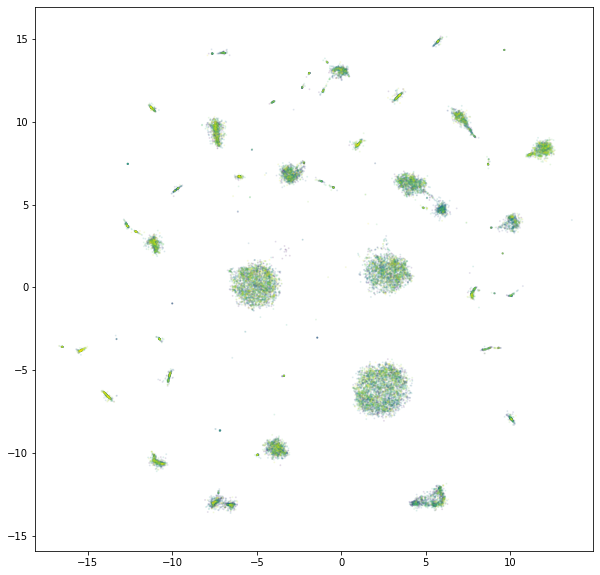

chunk 5
Mar 13 03:29:53 PM: edges.device (cpu) does not match requested device (cuda); copying edges to requested device.
Mar 13 03:29:53 PM: distortion_function device (cpu) does not match requested device (cuda); making a copy of distortion_function
Mar 13 03:29:53 PM: Fitting a anchored embedding into R^2, for a graph with 25338 items and 108002 edges.
Mar 13 03:29:53 PM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Mar 13 03:29:53 PM: iteration 000 | distortion 56.618027 | residual norm 0.126146 | step length 1227.71 | percent change 13.8259
Mar 13 03:29:53 PM: iteration 030 | distortion 1.057973 | residual norm 0.000297413 | step length 1 | percent change 0.0981607
Mar 13 03:29:53 PM: iteration 060 | distortion 1.056856 | residual norm 1.173e-05 | step length 1 | percent change 0.00385744
Mar 13 03:29:53 PM: Converged in 062 iterations, with residual norm 9.48419e-06
Mar 13 03:29:53 PM: Finished fitting in 0.249 seconds and 62 iterations.
Mar 13 03:29:53 PM

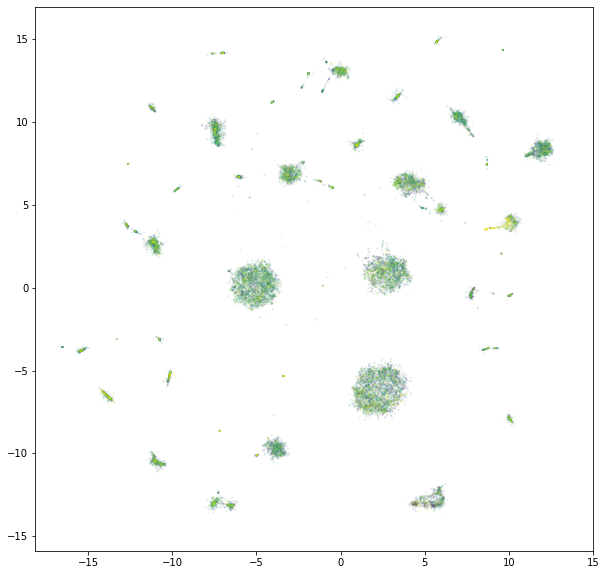

chunk 6
Mar 13 03:29:56 PM: edges.device (cpu) does not match requested device (cuda); copying edges to requested device.
Mar 13 03:29:56 PM: distortion_function device (cpu) does not match requested device (cuda); making a copy of distortion_function
Mar 13 03:29:56 PM: Fitting a anchored embedding into R^2, for a graph with 27357 items and 116926 edges.
Mar 13 03:29:56 PM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Mar 13 03:29:56 PM: iteration 000 | distortion 55.243015 | residual norm 0.120001 | step length 412.097 | percent change 4.35428
Mar 13 03:29:56 PM: iteration 030 | distortion 1.102164 | residual norm 0.000553345 | step length 1 | percent change 0.0656714
Mar 13 03:29:56 PM: Converged in 060 iterations, with residual norm 6.59568e-06
Mar 13 03:29:56 PM: Finished fitting in 0.187 seconds and 60 iterations.
Mar 13 03:29:56 PM: average distortion 1.1 | residual norm 6.6e-06
Mar 13 03:29:56 PM: edges.device (cpu) does not match requested device (cuda)

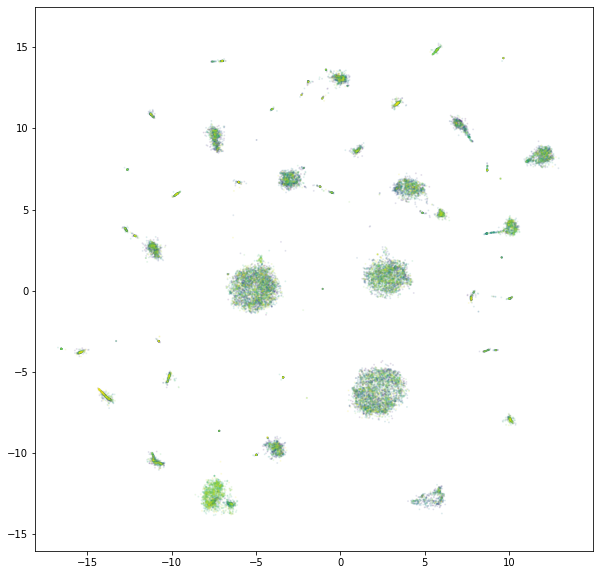

chunk 7
Mar 13 03:29:58 PM: edges.device (cpu) does not match requested device (cuda); copying edges to requested device.
Mar 13 03:29:58 PM: distortion_function device (cpu) does not match requested device (cuda); making a copy of distortion_function
Mar 13 03:29:58 PM: Fitting a anchored embedding into R^2, for a graph with 29624 items and 127221 edges.
Mar 13 03:29:58 PM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Mar 13 03:29:58 PM: iteration 000 | distortion 59.001350 | residual norm 0.120893 | step length 2204.08 | percent change 21.2267
Mar 13 03:29:58 PM: iteration 030 | distortion 0.923695 | residual norm 0.000483783 | step length 1 | percent change 0.137554
Mar 13 03:29:58 PM: iteration 060 | distortion 0.920934 | residual norm 1.59111e-05 | step length 1 | percent change 0.00332031
Mar 13 03:29:58 PM: Converged in 066 iterations, with residual norm 9.54242e-06
Mar 13 03:29:58 PM: Finished fitting in 0.247 seconds and 66 iterations.
Mar 13 03:29:58 P

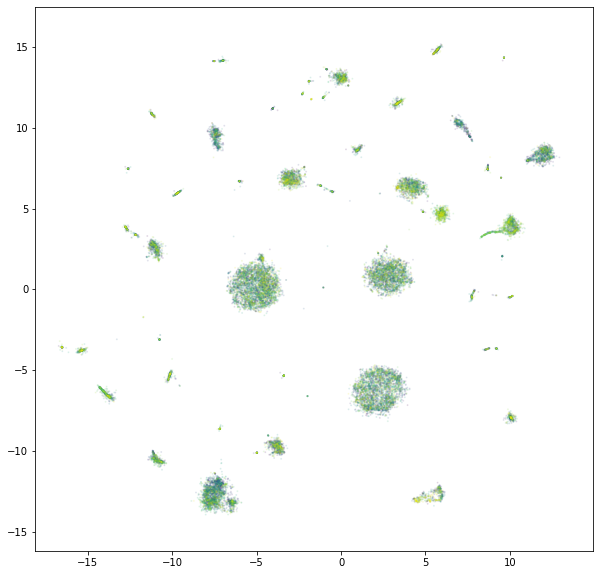

chunk 8
Mar 13 03:30:00 PM: edges.device (cpu) does not match requested device (cuda); copying edges to requested device.
Mar 13 03:30:00 PM: distortion_function device (cpu) does not match requested device (cuda); making a copy of distortion_function
Mar 13 03:30:00 PM: Fitting a anchored embedding into R^2, for a graph with 29117 items and 124890 edges.
Mar 13 03:30:00 PM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Mar 13 03:30:00 PM: iteration 000 | distortion 51.595795 | residual norm 0.112327 | step length 1828.03 | percent change 16.2903
Mar 13 03:30:00 PM: iteration 030 | distortion 1.124503 | residual norm 0.000188967 | step length 1 | percent change 0.0271872
Mar 13 03:30:00 PM: Converged in 048 iterations, with residual norm 7.76399e-06
Mar 13 03:30:00 PM: Finished fitting in 0.184 seconds and 48 iterations.
Mar 13 03:30:00 PM: average distortion 1.12 | residual norm 7.8e-06
Mar 13 03:30:01 PM: edges.device (cpu) does not match requested device (cuda

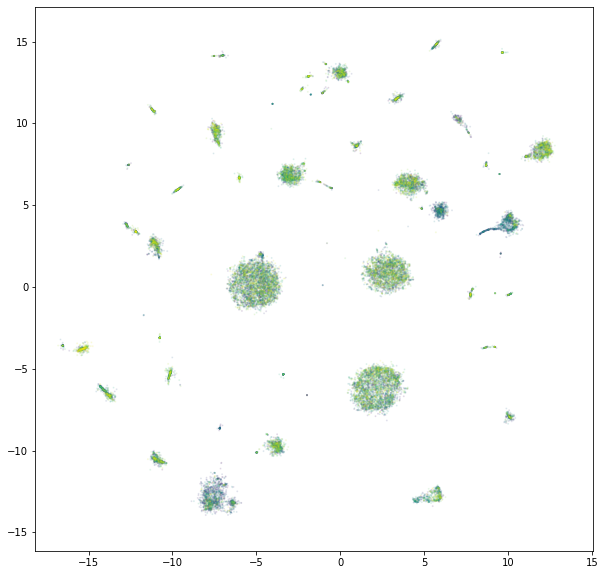

chunk 9
Mar 13 03:30:02 PM: edges.device (cpu) does not match requested device (cuda); copying edges to requested device.
Mar 13 03:30:02 PM: distortion_function device (cpu) does not match requested device (cuda); making a copy of distortion_function
Mar 13 03:30:02 PM: Fitting a anchored embedding into R^2, for a graph with 27607 items and 118305 edges.
Mar 13 03:30:02 PM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Mar 13 03:30:02 PM: iteration 000 | distortion 54.335194 | residual norm 0.122571 | step length 2309.27 | percent change 24.1178
Mar 13 03:30:02 PM: iteration 030 | distortion 0.928257 | residual norm 0.000644319 | step length 1 | percent change 0.414657
Mar 13 03:30:02 PM: iteration 060 | distortion 0.919601 | residual norm 5.11483e-05 | step length 1 | percent change 0.0160499
Mar 13 03:30:02 PM: Converged in 073 iterations, with residual norm 9.50069e-06
Mar 13 03:30:02 PM: Finished fitting in 0.227 seconds and 73 iterations.
Mar 13 03:30:02 PM

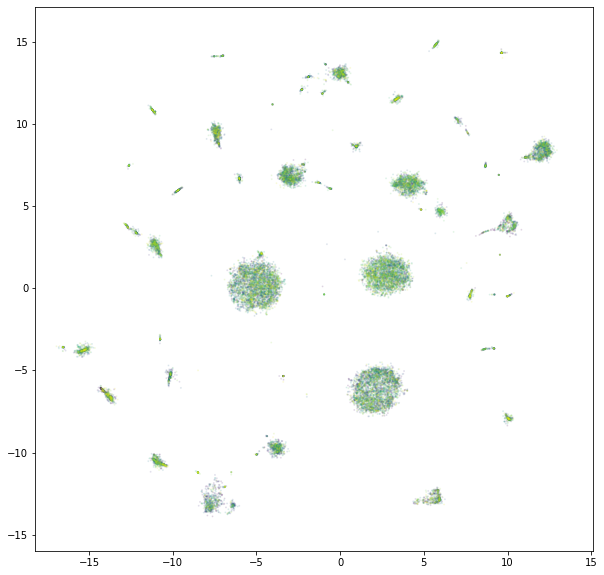

chunk 10
Mar 13 03:30:04 PM: edges.device (cpu) does not match requested device (cuda); copying edges to requested device.
Mar 13 03:30:04 PM: distortion_function device (cpu) does not match requested device (cuda); making a copy of distortion_function
Mar 13 03:30:04 PM: Fitting a anchored embedding into R^2, for a graph with 28848 items and 123381 edges.
Mar 13 03:30:04 PM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Mar 13 03:30:04 PM: iteration 000 | distortion 51.567299 | residual norm 0.112357 | step length 2396.79 | percent change 23.8231
Mar 13 03:30:04 PM: iteration 030 | distortion 0.970269 | residual norm 0.000469992 | step length 1 | percent change 0.287736
Mar 13 03:30:04 PM: Converged in 051 iterations, with residual norm 8.54767e-06
Mar 13 03:30:04 PM: Finished fitting in 0.168 seconds and 51 iterations.
Mar 13 03:30:04 PM: average distortion 0.969 | residual norm 8.5e-06
Mar 13 03:30:05 PM: edges.device (cpu) does not match requested device (cud

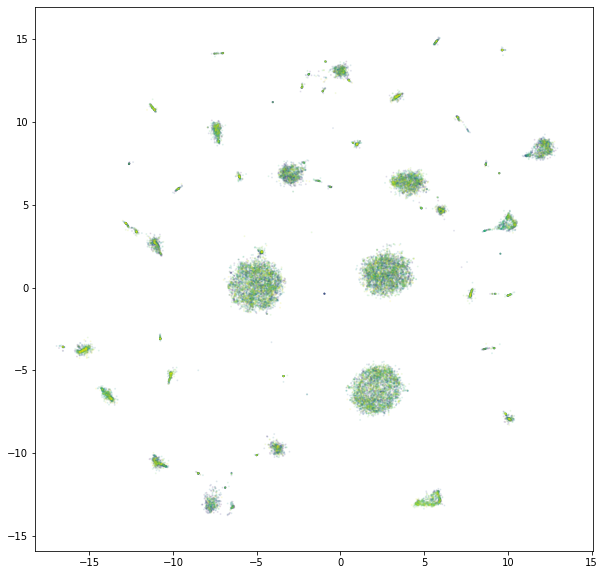

chunk 11
Mar 13 03:30:06 PM: edges.device (cpu) does not match requested device (cuda); copying edges to requested device.
Mar 13 03:30:06 PM: distortion_function device (cpu) does not match requested device (cuda); making a copy of distortion_function
Mar 13 03:30:06 PM: Fitting a anchored embedding into R^2, for a graph with 29368 items and 125914 edges.
Mar 13 03:30:06 PM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Mar 13 03:30:06 PM: iteration 000 | distortion 52.778328 | residual norm 0.11568 | step length 2371.96 | percent change 23.3522
Mar 13 03:30:06 PM: iteration 030 | distortion 0.838660 | residual norm 7.24952e-05 | step length 1 | percent change 0.0191461
Mar 13 03:30:06 PM: Converged in 043 iterations, with residual norm 6.54132e-06
Mar 13 03:30:06 PM: Finished fitting in 0.134 seconds and 43 iterations.
Mar 13 03:30:06 PM: average distortion 0.839 | residual norm 6.5e-06
Mar 13 03:30:07 PM: edges.device (cpu) does not match requested device (cud

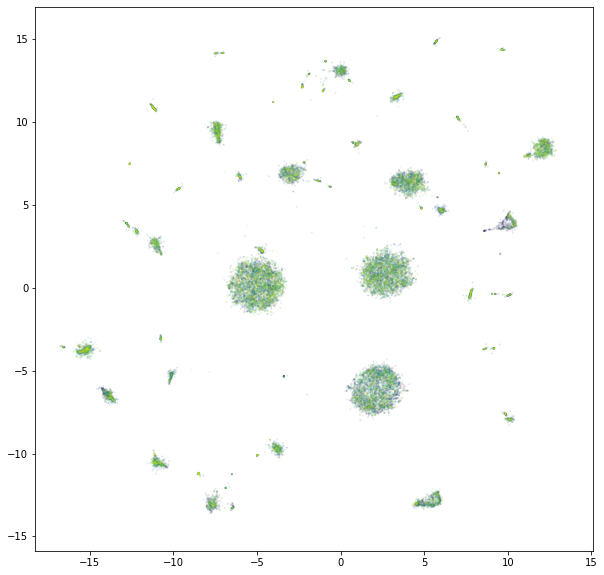

chunk 12
Mar 13 03:30:09 PM: edges.device (cpu) does not match requested device (cuda); copying edges to requested device.
Mar 13 03:30:09 PM: distortion_function device (cpu) does not match requested device (cuda); making a copy of distortion_function
Mar 13 03:30:09 PM: Fitting a anchored embedding into R^2, for a graph with 36207 items and 158461 edges.
Mar 13 03:30:09 PM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Mar 13 03:30:09 PM: iteration 000 | distortion 42.800411 | residual norm 0.0949321 | step length 1788.07 | percent change 14.6023
Mar 13 03:30:09 PM: iteration 030 | distortion 0.748672 | residual norm 0.000434832 | step length 1 | percent change 0.104975
Mar 13 03:30:09 PM: Converged in 057 iterations, with residual norm 7.24293e-06
Mar 13 03:30:09 PM: Finished fitting in 0.235 seconds and 57 iterations.
Mar 13 03:30:09 PM: average distortion 0.747 | residual norm 7.2e-06
Mar 13 03:30:10 PM: edges.device (cpu) does not match requested device (cu

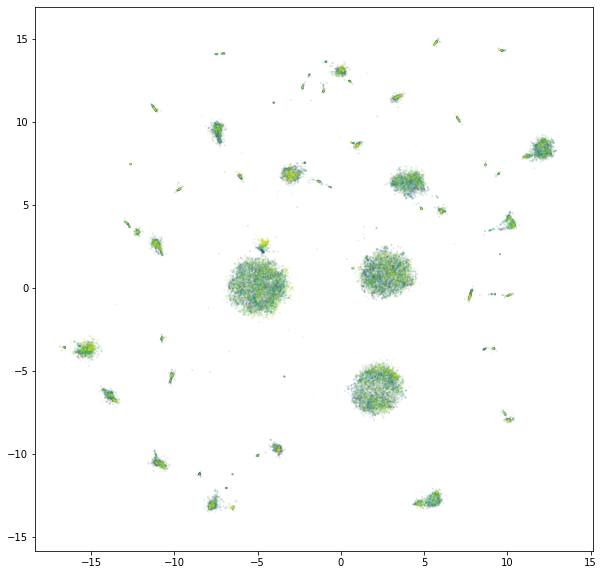

chunk 13
Mar 13 03:30:11 PM: edges.device (cpu) does not match requested device (cuda); copying edges to requested device.
Mar 13 03:30:11 PM: distortion_function device (cpu) does not match requested device (cuda); making a copy of distortion_function
Mar 13 03:30:11 PM: Fitting a anchored embedding into R^2, for a graph with 21839 items and 93425 edges.
Mar 13 03:30:11 PM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Mar 13 03:30:11 PM: iteration 000 | distortion 1.624433 | residual norm 0 | step length 1 | percent change 0
Mar 13 03:30:11 PM: Converged in 001 iterations, with residual norm 0
Mar 13 03:30:11 PM: Finished fitting in 0.006 seconds and 1 iterations.
Mar 13 03:30:11 PM: average distortion 1.62 | residual norm 0.0e+00
Mar 13 03:30:12 PM: edges.device (cpu) does not match requested device (cuda); copying edges to requested device.
Mar 13 03:30:12 PM: distortion_function device (cpu) does not match requested device (cuda); making a copy of distortion

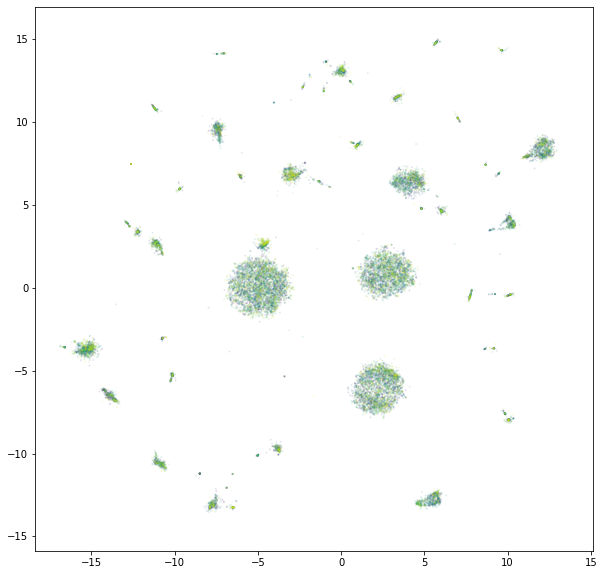

In [161]:
x_all = np.zeros((n_spikes, embedding_dim))

# subset graph
for chunk in tqdm(range(n_chunks - 1)):
    (chunk_graph_idx, chunk_graph_vals, index_cur, index_next) = grab_graph_chunk(
        chunk_idx, chunk, nn_index_array, nn_dist_array
    )
    chunk_csr = construct_symmetric_graph_from_idx_vals(
        chunk_graph_idx, chunk_graph_vals
    )
    n_cur = np.sum(index_cur)
    #
    print("chunk {}".format(chunk))
    if chunk == 0:
        x = embed_graph(chunk_csr, prev_embeddings=None, prev_idx=None)
        x_all[index_cur] = x[:n_cur]
        x_all[index_next] = x[n_cur:]
    else:

        x = embed_graph(
            chunk_csr,
            prev_embeddings=x_all[index_cur],
            prev_idx=np.arange(n_cur),
        )
        x_all[index_next] = x[n_cur:]
        
    xmin, xmax = np.percentile(x[:,0], (1,99))
    ymin, ymax = np.percentile(x[:,1], (1,99))
    padding = 0.1
    xpad = (xmax - xmin)* padding
    ypad = (ymax - ymin)* padding
    xmin -=xpad
    xmax +=xpad
    ymin-=ypad
    ymax+=xpad

    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(x[:,0], x[:,1], s=1, alpha = 0.1,  c = np.arange(len(x)))
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    plt.show()

In [165]:
np.where(chunk_csr[-1000].todense())

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([  745,  2008,  2282,  3372,  3806,  6951,  8689, 10163, 14485,
        15064, 15972, 18690, 20578]))

In [166]:
x = x_all

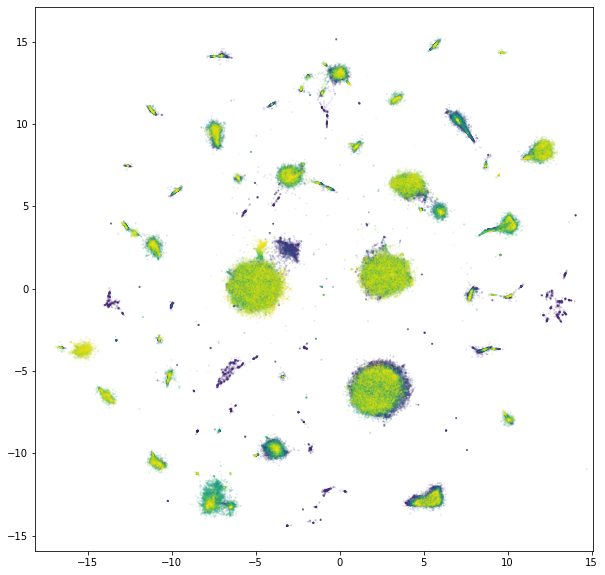

In [167]:
xmin, xmax = np.percentile(x[:,0], (1,99))
ymin, ymax = np.percentile(x[:,1], (1,99))
padding = 0.1
xpad = (xmax - xmin)* padding
ypad = (ymax - ymin)* padding
xmin -=xpad
xmax +=xpad
ymin-=ypad
ymax+=xpad

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x[:,0], x[:,1], s=1, alpha = 0.1,  c = np.arange(len(x)))
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.show()

### Soft clustering

In [168]:
# https://hdbscan.readthedocs.io/en/latest/soft_clustering.html

In [169]:
import hdbscan

In [170]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True, core_dist_n_jobs=n_jobs).fit(x)

In [171]:
np.unique(clusterer.labels_)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [172]:
clusterer.probabilities_.shape

(221083,)

In [183]:
clusterer.probabilities_

array([1.        , 1.        , 0.94453002, ..., 0.40274328, 1.        ,
       1.        ])

In [173]:
from distinctipy import distinctipy

In [174]:
import seaborn as sns

In [175]:
N = len(np.unique(clusterer.labels_))
print(N)

345


In [176]:
colors = sns.color_palette('tab20', N)
np.random.shuffle(colors)
#colors = distinctipy.get_colors(N)
colors[0] = (0.9,0.9,0.9)

In [177]:
color_dict = dict(zip(np.unique(clusterer.labels_), colors))

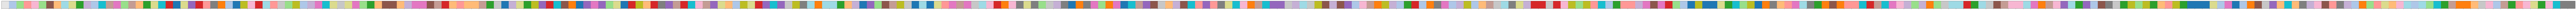

In [178]:
sns.palplot(colors)

In [179]:
c = [color_dict[i] for i in clusterer.labels_]

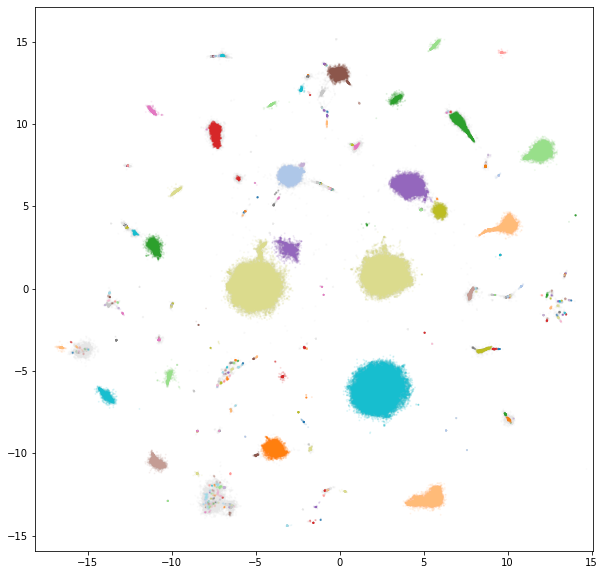

In [180]:
xmin, xmax = np.percentile(x[:,0], (1,99))
ymin, ymax = np.percentile(x[:,1], (1,99))
padding = 0.1
xpad = (xmax - xmin)* padding
ypad = (ymax - ymin)* padding
xmin -=xpad
xmax +=xpad
ymin-=ypad
ymax+=xpad

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(
    x[:, 0],
    x[:, 1],
    s=1,
    c=c,
    alpha=0.1,
)
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.show()

(-65.0, 235.0)

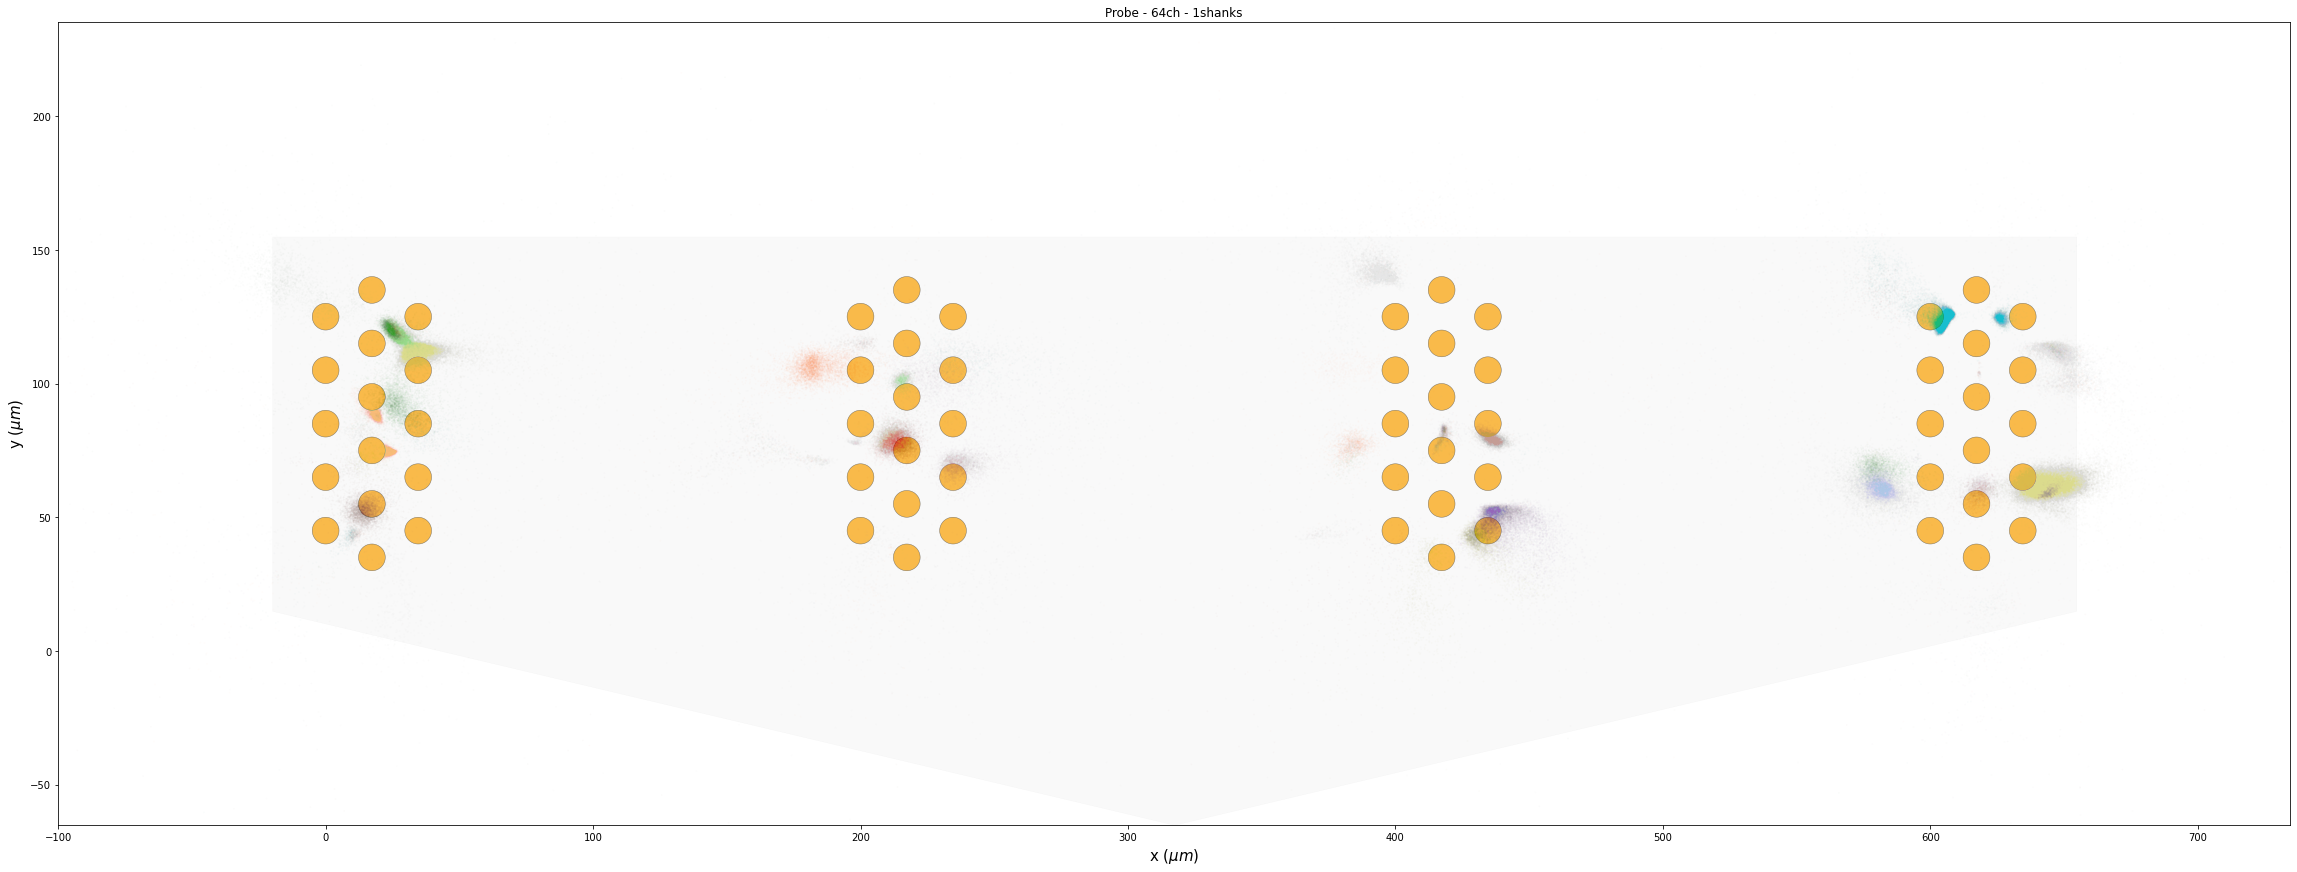

In [181]:
probe = rec_preprocessed.get_probe()
fig, ax = plt.subplots(figsize=(40, 20))
plot_probe(rec.get_probe(), ax=ax, probe_shape_kwargs={
    'facecolor': (0,0,0,0.01),
    'alpha':0.025
})
ax.scatter(peak_locations["x"], peak_locations["y"], c=c, s=1, alpha=0.01)
ax.set_xlim(probe_bounds_x)
ax.set_ylim(probe_bounds_y)

In [182]:
# cluster per each timebin
# 

### TODO  set cluster labels + probabilities for both pre and post independantly 
- module returns: 
    - graph across spike dataset
    - embeddings across spike dataset
    - clusters proposed for each chunk
    - probabilities of clusters proposed for each chunk
    - templates for each cluster
    - 
- merge clusters
    - based upon overlap (and addtl features?) merge templates across time 